(1001, 256, 512)


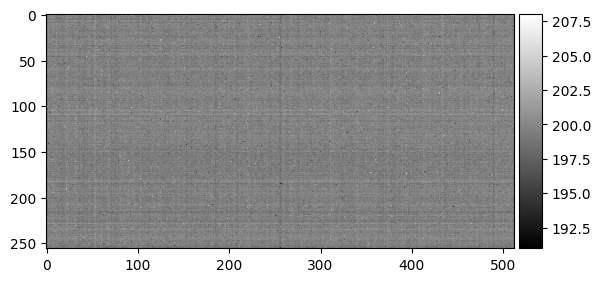

In [1]:
from astropy.io import fits
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import matplotlib.pyplot as plt

name = 'SP20230713212625.fits'
hdul = fits.open('SP20230713212625.fits')
data = hdul[0].data
print(np.shape(data))
master_bias = np.median(data, axis=0)
# fig = plt.figure(figsize=(10, 10))
# im = plt.imshow(master_bias, cmap = 'gray')

ax = plt.gca()
im = ax.imshow(master_bias, cmap = 'gray')
    
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
   
plt.colorbar(im, cax=cax)

plt.savefig('master_bias.png')
hdul.close()

SIMPLE  =                    T / file does conform to FITS standard             BITPIX  =                   16 / number of bits per data pixel                  NAXIS   =                    3 / number of data axes                            NAXIS1  =                  512 / length of data axis 1                          NAXIS2  =                  256 / length of data axis 2                          NAXIS3  =                 3002 / length of data axis 3                          EXTEND  =                    T / FITS dataset may contain extensions            COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H BZERO   =                32768 / offset data range to that of unsigned short    BSCALE  =                    1 / default scaling factor                         ACT     =                  -1.                                                  NUMKIN  =                 3002 / Series 

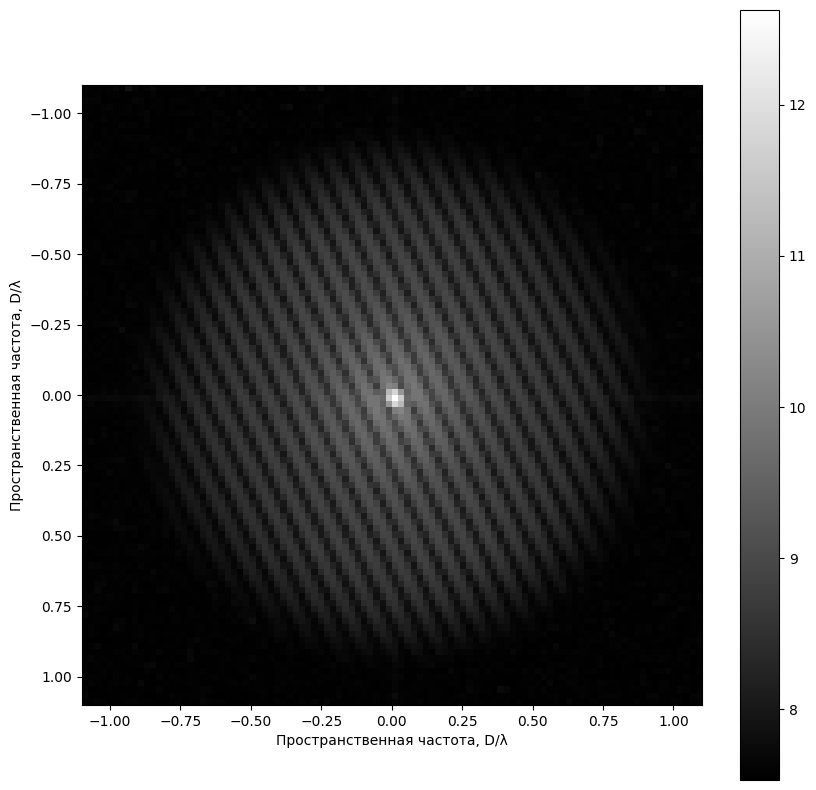

In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
from numpy.fft import fft2

name2 = 'SP20230713202559.fits'
hdul2 = fits.open('SP20230713202559.fits')
data2 = hdul2[0].data
print(hdul2[0].header)
nframes = hdul2[0].header['NAXIS3']
frames_wo_gauss = []
frames = []
powerspectrum = np.zeros((100, 100))

def mean_func(data): #возможно муторно, но выделяем 6 областей вне основного кадра

   lu=np.mean(data[0:ind[0], 0:ind[1]-50])
   ru=np.mean(data[0:ind[0], ind[1]+50:512])
   ld=np.mean(data[ind[0]:256, 0:ind[1]-50])
   rd=np.mean(data[ind[0]:256, ind[1]+50:512])
   up=np.mean(data[0:ind[0]-50, ind[1]-50:ind[1]+50])
   down=np.mean(data[ind[0]+50:256, ind[1]-50:ind[1]+50])
   return (lu, ru, ld, rd, up, down)

for i in range(nframes):
# for i in range(1):
    # plt.figure(figsize=(10, 20)) #эта и строчка ниже для того, чтобы посмотреть на сырые кадры
    # plt.imshow(data2[i], cmap='gray')
    frame = data2[i] - master_bias
#    frames_wo_gauss.append(frame) #массв сырых кадров
    smoothed_frame = gaussian_filter(frame, sigma=5)
    # frames.append(smoothed_frame) #массив после гаусса

    ind = np.unravel_index(np.argmax(smoothed_frame, axis=None), smoothed_frame.shape)
    
    m = np.mean(mean_func(frame))
    frame = frame - m
    frame = frame[ind[0]-50:ind[0]+50, ind[1]-50:ind[1]+50]
    # fig = plt.figure(figsize=(10, 10))
    # im = plt.imshow(frame, cmap='gray')
    # fig.colorbar(im) 

    try:
        fshift = np.fft.fftshift(fft2(frame))
        fshift = (np.abs(fshift))**2
        # fig = plt.figure(figsize=(10, 10))
        # im = plt.imshow(fshift, cmap='gray')
        # fig.colorbar(im) 
        powerspectrum += fshift
    except: 
        continue

powerspectrum = powerspectrum / 1000
# fig = plt.figure(figsize=(10, 20))
# im = plt.imshow(frames[0], cmap='gray')
logspectrum = np.log10(powerspectrum)
fig = plt.figure(figsize=(10, 10))
im = plt.imshow(logspectrum, cmap = 'gray', extent=[-1.1, 1.1, 1.1, -1.1])
plt.xlabel("Пространственная частота, D/λ")
plt.ylabel("Пространственная частота, D/λ")
fig.colorbar(im)
plt.savefig('log_powerspectrum.png')
# hdul2.close()
# plt.figure(figsize=(10, 20))
# plt.imshow(frames[1], cmap='gray')
# print(frames[0])
# plt.figure(figsize=(10, 20))
# plt.imshow(data2[101], cmap='gray')
# print(np.max(data2[101]))
# print(np.max(data2[100]))

/tmp/ipykernel_7990/543915906.py:20: RuntimeWarning: invalid value encountered in log10
  im = plt.imshow(np.log10(powerspectrum), cmap = 'gray', vmin=6, vmax=7.5, extent=[-1.1, 1.1, 1.1, -1.1]) #это в мсд , extent=[-101.65,101.65,101.65,-101.65]


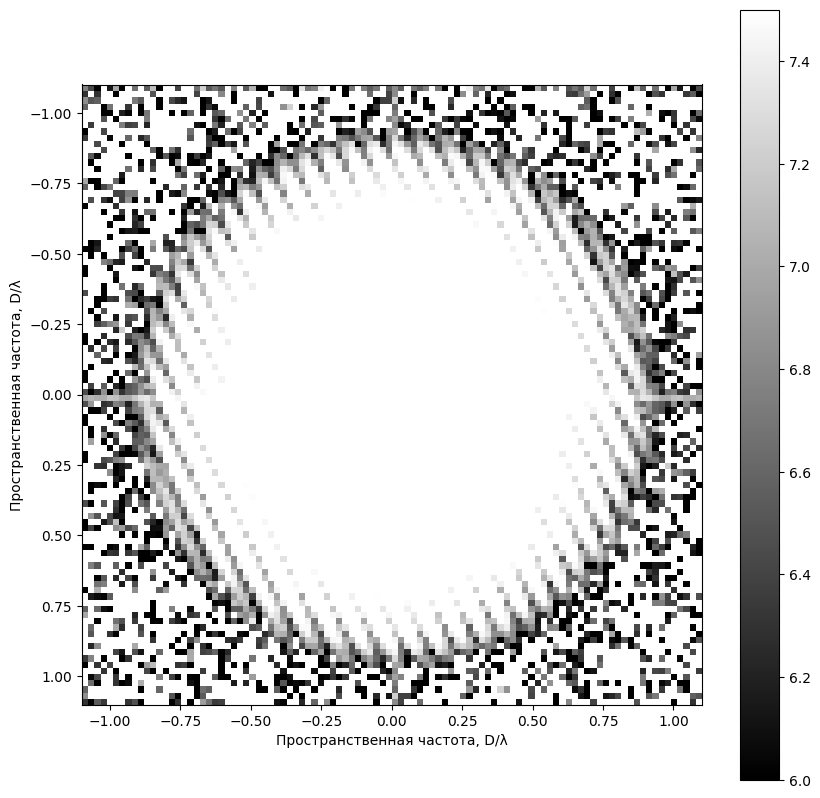

In [3]:
x = np.linspace(-50, 50, 100)
y = np.linspace(-50, 50, 100)
xx, yy = np.meshgrid(x, y)
zz = np.sqrt(xx**2 + yy**2)
mask = zz > 45
summed_spectrum_outside_of_mask = np.sum(powerspectrum * mask)
averaged_spectrum_outside_of_mask = summed_spectrum_outside_of_mask / np.sum(mask)
# print(averaged_spectrum_outside_of_mask)
powerspectrum = powerspectrum - averaged_spectrum_outside_of_mask

# im = plt.imshow(logspectrum, cmap = 'gray', extent=[-1.1, 1.1, 1.1, -1.1])
# plt.xlabel("Пространственная частота, D/λ")
# plt.ylabel("Пространственная частота, D/λ")
# fig.colorbar(im)
# plt.savefig('log_powerspectrum.png')

# plt.imshow(mask)

fig = plt.figure(figsize=(10, 10))
im = plt.imshow(np.log10(powerspectrum), cmap = 'gray', vmin=6, vmax=7.5, extent=[-1.1, 1.1, 1.1, -1.1]) #это в мсд , extent=[-101.65,101.65,101.65,-101.65]
plt.xlabel("Пространственная частота, D/λ")
plt.ylabel("Пространственная частота, D/λ")
fig.colorbar(im)
plt.savefig('masked_powerspectrum.png')

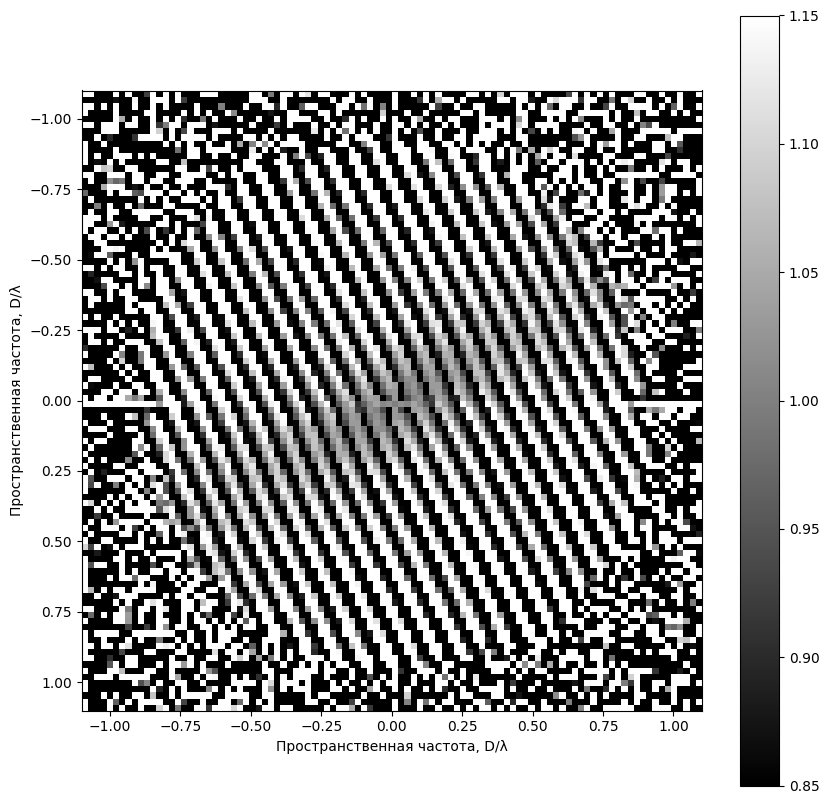

In [4]:
import numpy as np
import cv2
rotated_powerspectrum = np.zeros((100, 100))

def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

for i in range(0,360):
    partially_rotated_powerspectrum = rotate_image(powerspectrum, 1)
    rotated_powerspectrum = rotated_powerspectrum + partially_rotated_powerspectrum
rotated_powerspectrum = rotated_powerspectrum / 360
rotated_powerspectrum = powerspectrum / rotated_powerspectrum


fig = plt.figure(figsize=(10, 10))
im = plt.imshow(rotated_powerspectrum, cmap = 'gray', vmin=0.85, vmax=1.15, extent=[-1.1, 1.1, 1.1, -1.1]) #это в мсд , extent=[-101.65,101.65,101.65,-101.65]
plt.xlabel("Пространственная частота, D/λ")
plt.ylabel("Пространственная частота, D/λ")
fig.colorbar(im)
plt.savefig('rotated_powerspectrum.png')

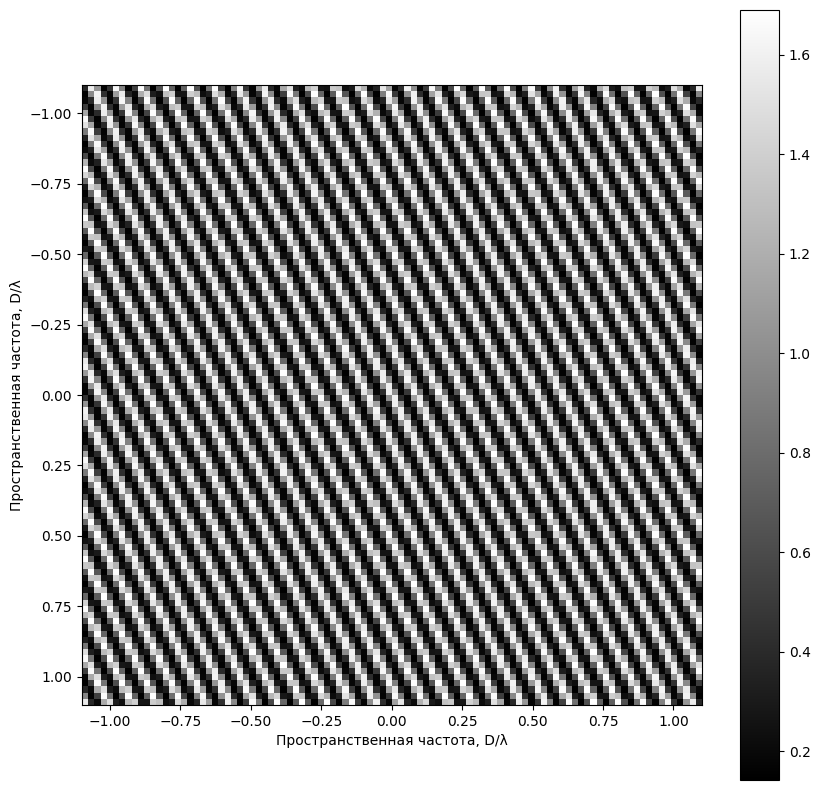

In [17]:
def approximation_function(f_x, f_y, delta_x, delta_y, q, coefficient):
    delta_x2 = delta_x/(206265)
    delta_y2 = delta_y/(206265)
    O = ((1 + q)**(-2))*(1 + q**2 + 2*q*np.cos(2*np.pi*(f_x*delta_x2 + f_y*delta_y2))) * coefficient
    return((np.abs(O))**2)

angular_scale = (20 / 1000)/(3600*180/np.pi) # RAD
Nx = 100 # array size
freq_scale = 1/(angular_scale*Nx)
f_x, f_y = np.meshgrid(x*freq_scale, y*freq_scale)
# delta_x = 0.8*10**(-7)
# delta_y = 8*10**(-7)
delta_x = 0.505
delta_y = -0.252
q = 0.3
coefficient = 1.3
model_image = approximation_function(f_x, f_y, delta_x, delta_y, q, coefficient)

# totr = total_residual((delta_x,delta_y,q),rotated_powerspectrum,f_x,f_y)
#print(f'total residual:{totr}')

fig = plt.figure(figsize=(10, 10))
im = plt.imshow(model_image, cmap = 'gray', extent=[-1.1, 1.1, 1.1, -1.1]) #здесь в пкс
plt.xlabel("Пространственная частота, D/λ")
plt.ylabel("Пространственная частота, D/λ")
fig.colorbar(im)
plt.savefig('model.png')

(0.505, -0.252, 0.3, 1.3)
[ 0.49224851 -0.22642646  0.09130178  1.13912333]


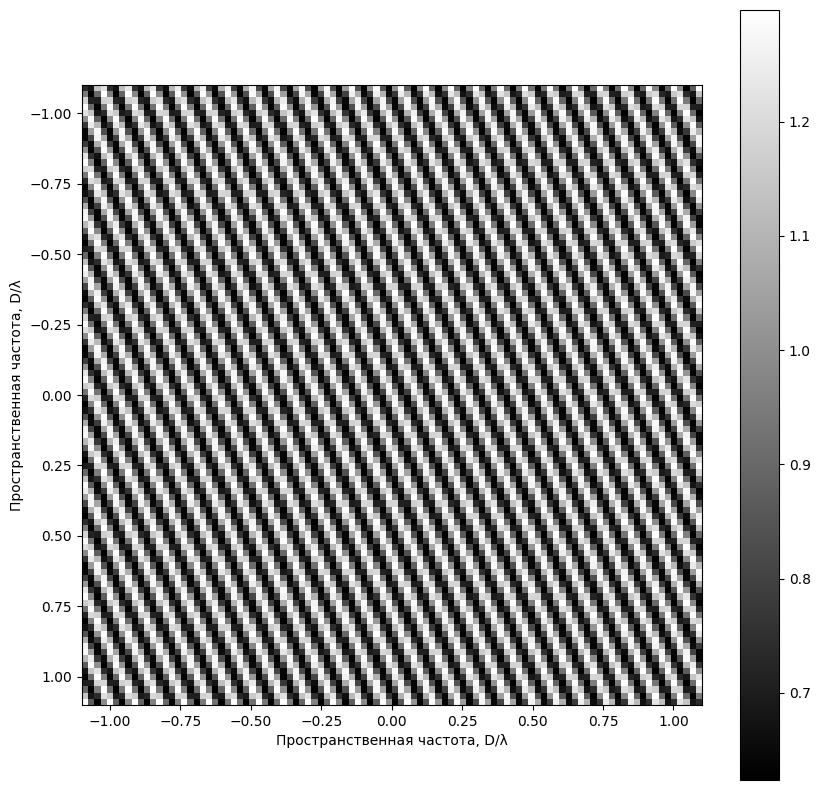

In [18]:
from scipy.optimize import least_squares

def total_residual(coeffs,observed_powerspectrum,f_x,f_y, mask):
    delta_x=coeffs[0]
    delta_y=coeffs[1]
    q=coeffs[2]
    coefficient=coeffs[3]
    model = approximation_function(f_x, f_y, delta_x, delta_y, q, coefficient)
    devs = (model - observed_powerspectrum)*mask
    return np.reshape(devs,(10000,))
#    return np.sum(((model - observed_powerspectrum)*mask)**2)

mask = zz < 30
# plt.imshow(mask)
coeffs0 = (delta_x, delta_y, q, coefficient)
print(coeffs0)
estimated_coeffs = least_squares(total_residual,coeffs0,args=(rotated_powerspectrum,f_x,f_y, mask))
print(estimated_coeffs.x)
model_image_after_approximation = approximation_function(f_x, f_y, estimated_coeffs.x[0], estimated_coeffs.x[1], estimated_coeffs.x[2], estimated_coeffs.x[3])
#model_image_after_approximation = approximation_function(f_x, f_y, 0.5, -0.25, 0.4, 1.3)

#autocorr = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(rotated_powerspectrum*mask)))

fig = plt.figure(figsize=(10, 10))
im = plt.imshow(model_image_after_approximation, cmap = 'gray', extent=[-1.1, 1.1, 1.1, -1.1]) #здесь в пкс
plt.xlabel("Пространственная частота, D/λ")
plt.ylabel("Пространственная частота, D/λ")
fig.colorbar(im)
plt.savefig('optimized_model.png')

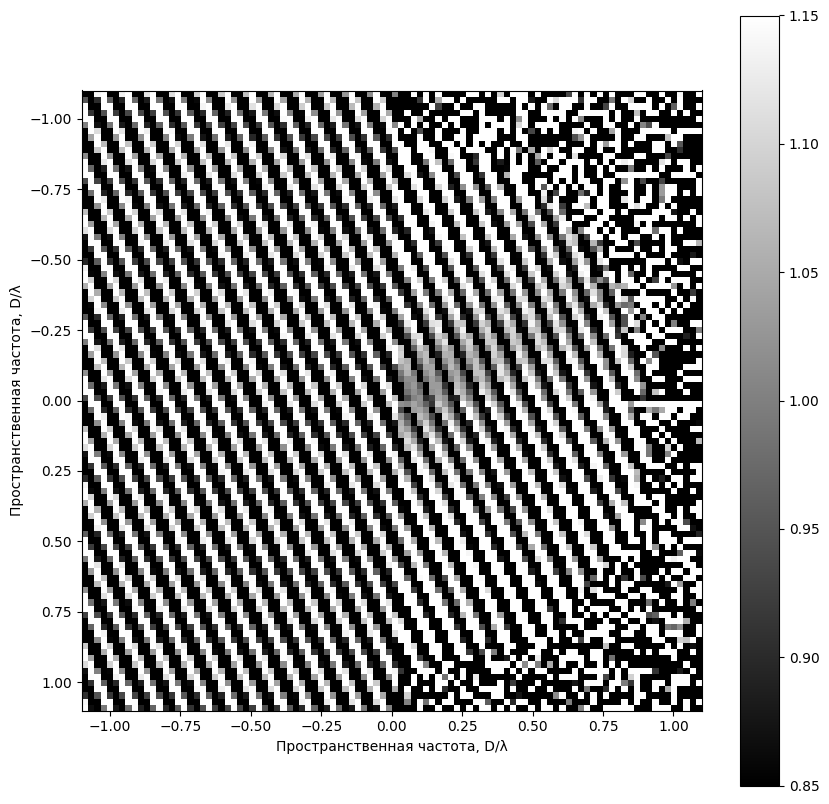

In [19]:
concatenated_images_of_model_and_reality = np.zeros((100, 100))

concatenated_images_of_model_and_reality += np.hstack((model_image_after_approximation[:, 0:51], rotated_powerspectrum[:, 51:101]))
fig = plt.figure(figsize=(10, 10))
im = plt.imshow(concatenated_images_of_model_and_reality, cmap = 'gray', extent=[-1.1, 1.1, 1.1, -1.1], vmin=0.85, vmax=1.15) #здесь в пкс
plt.xlabel("Пространственная частота, D/λ")
plt.ylabel("Пространственная частота, D/λ")
fig.colorbar(im)
plt.savefig('concatenated_model_and_reality.png')